# CSCA 5642: Introduction to Deep Learning week5 assignment: GANs
Author: Nobuo Takizawa  
GitHub Repository: https://github.com/nobuyo/intro-to-dl/tree/main/week5

# Description of the Problem  
This section provides an overview of the problem and explains the evaluation method.

## Challenge Overview  
- This study is based on the Kaggle competition *I’m Something of a Painter Myself*, which focuses on image style transfer using GANs.  
- The goal is to convert photos into Monet-style paintings.  
- According to the competition rules, the task is to build a GAN that generates 7,000 to 10,000 Monet-style images from photo inputs.

## Task Evaluation  
- The generated images are uploaded and evaluated using MiFID (*Memorization-informed Fréchet Inception Distance*).  
- A lower MiFID score indicates better model performance.

## About MiFID  

- MiFID is based on FID (Fréchet Inception Distance), a standard metric for evaluating GAN-generated images.  
- FID measures the similarity between generated images and real images by extracting feature representations from InceptionV3, a pre-trained model.  
- However, FID has a limitation:  
  - If a GAN simply memorizes and reproduces training samples instead of creating meaningful transformations, FID cannot detect this issue.  
  - This happens because FID only measures how similar the generated images are to real ones but does not account for overfitting or memorization.  

### How MiFID Improves FID
- MiFID adjusts for memorization bias by incorporating a cosine similarity measure between generated images and the training dataset.  
- If the generated images are too similar to the training set (i.e., direct copies), MiFID penalizes the score, ensuring that the model is learning a meaningful transformation rather than simply memorizing and reproducing the training data.

# Load libraries, Dataset

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import math

import cv2

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.17.1


In [3]:
GCS_PATH = KaggleDatasets().get_gcs_path()

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [4]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [6]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

# Description of the Data  

## Properties of the Given Dataset  
- The dataset consists of Monet paintings as input for learning Monet’s artistic style and photos to which the style will be applied.  
- Unlike datasets where images have a one-to-one correspondence (e.g., maps and aerial photos), these two groups are completely independent and do not form matched pairs.  
- The task falls under unpaired image-to-image translation, making CycleGAN the most suitable approach for learning and applying the Monet style.  

In [17]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

### Displaying the Image
Since the images are normalized to the range [−1,1], they need to be denormalized for proper visualization.

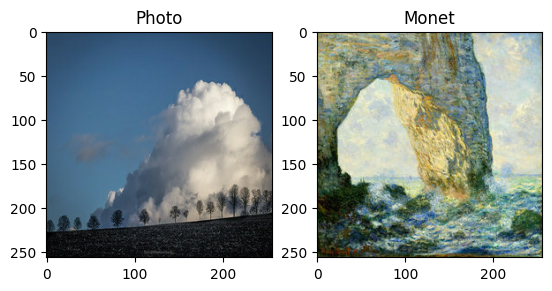

In [18]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

## Size, Dimension, and Format

From [the competition's data description](https://www.kaggle.com/competitions/gan-getting-started/data), dimension of the data is follows:

- monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
- photo_tfrec - 7028 photos sized 256x256 in TFRecord format

Each image consists of three color channels (RGB) and has a shape of (256, 256, 3), where:  
- (256, 256) represents the spatial dimensions (height × width).  
- 3 corresponds to the color channels (Red, Green, Blue).

In [19]:
example_monet[0].shape

TensorShape([256, 256, 3])

# EDA

In this section, we conduct an exploratory analysis of the dataset.  
Specifically, we examine:  
- **Statistical properties of pixel values** in the input images.  
- **Edge characteristics** present in the images to understand structural differences between domains.

In [20]:
from tqdm import tqdm

def compute_image_statistics(dataset, num_samples=100):
    mean_values = []
    std_values = []

    for image in tqdm(dataset.take(num_samples), desc="Processing images"):
        img_np = image.numpy() * 0.5 + 0.5 # de-normalization
        mean_values.append(np.mean(img_np, axis=(0, 1))) # mean of R/G/B
        std_values.append(np.std(img_np, axis=(0, 1))) # std of R/G/B

    mean_values = np.array(mean_values)
    std_values = np.array(std_values)

    return mean_values.mean(axis=0), std_values.mean(axis=0)

In [21]:
monet_mean, monet_std = compute_image_statistics(monet_ds)
photo_mean, photo_std = compute_image_statistics(photo_ds)

Processing images: 100it [00:03, 30.22it/s]
Processing images: 100it [00:02, 48.45it/s]


- The RGB mean shows a noticeable bias, with blue (B) being lower.  
- The standard deviation (std) also appears to be smaller compared to photos discussed later.  
- These characteristics likely reflect Monet's artistic style, where colors are intentionally constrained within a specific palette rather than covering a broad range.

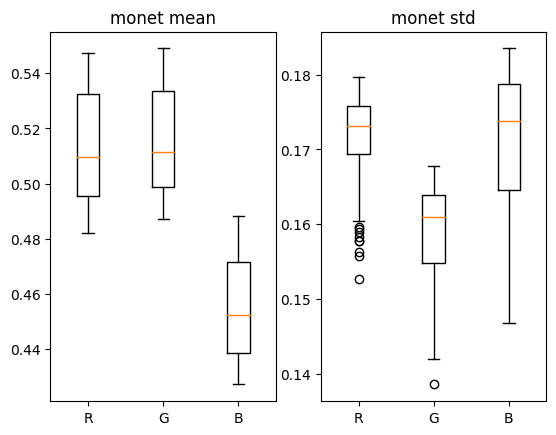

In [22]:
plt.subplot(121)
plt.title('monet mean')
plt.boxplot(monet_mean, labels=['R', 'G', 'B'])

plt.subplot(122)
plt.title('monet std')
plt.boxplot(monet_std, labels=['R', 'G', 'B'])

plt.show()

- The highest values are represented in green.  
- Photos exhibit a more balanced RGB mean, with less variation between channels.  
- The overall RGB mean in photos is lower than in Monet's paintings, suggesting that photos generally have softer, more muted colors.  
- Variance in photos is higher compared to Monet's paintings, likely because photos do not adhere to a consistent artistic style, whereas Monet’s works follow a more uniform color composition.

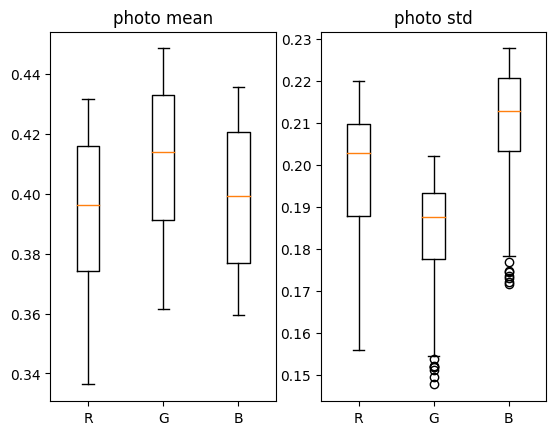

In [23]:
plt.subplot(121)
plt.title('photo mean')
plt.boxplot(photo_mean, labels=['R', 'G', 'B'])

plt.subplot(122)
plt.title('photo std')
plt.boxplot(photo_std, labels=['R', 'G', 'B'])

plt.show()

### Edge Analysis  

- When transforming images, preserving edge sharpness is crucial for maintaining visual detail.  
- If edges become overly blurred during the conversion process, the resulting image may lose important structural features, reducing its perceived quality.  
- By analyzing edge characteristics before and after transformation, we can assess whether the model effectively retains fine details or if additional adjustments are needed to enhance edge preservation.

Computing edge strength: 100it [00:03, 28.75it/s]
Computing edge strength: 100it [00:02, 46.09it/s]


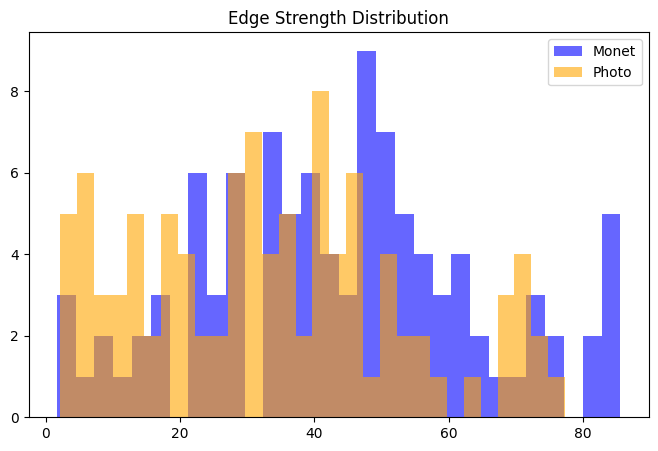

Monet - Mean Edge Strength: 43.99
Photo - Mean Edge Strength: 33.39


In [24]:
def compute_edge_strength(dataset, num_samples=100):
    edge_strengths = []
    
    for image in tqdm(dataset.take(num_samples), desc="Computing edge strength"):
        img_np = ((image.numpy() * 0.5 + 0.5) * 255).astype(np.uint8)  # de-normalization
        gray = cv2.cvtColor(img_np[0], cv2.COLOR_RGB2GRAY)  # convert to grayscale
        edges = cv2.Canny(gray, 100, 200)  # Canny Edge
        edge_strengths.append(np.mean(edges))
    
    return np.array(edge_strengths)

monet_edges = compute_edge_strength(monet_ds)
photo_edges = compute_edge_strength(photo_ds)

plt.figure(figsize=(8, 5))
plt.hist(monet_edges, bins=30, alpha=0.6, label="Monet", color="blue")
plt.hist(photo_edges, bins=30, alpha=0.6, label="Photo", color="orange")
plt.legend()
plt.title("Edge Strength Distribution")
plt.show()

print(f"Monet - Mean Edge Strength: {monet_edges.mean():.2f}")
print(f"Photo - Mean Edge Strength: {photo_edges.mean():.2f}")

- These results suggest that edges in Monet's paintings tend to be stronger compared to photos.  
- This aligns with the expectation that paintings created with brushstrokes naturally contain more prominent linear elements than photographs.  

### Next Step: Analyzing Edge Directions  
- We will now examine edge orientations in more detail.  
- Using the Sobel filter, we detect areas with sharp intensity differences in both horizontal and vertical directions, allowing us to understand the dominant structural patterns in each domain.

Computing orientations: 100it [00:03, 30.47it/s]
Computing orientations: 100it [00:02, 47.46it/s]


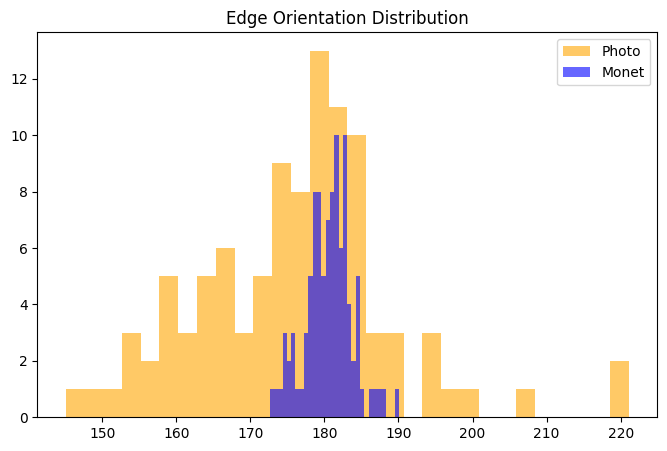

Monet - Mean Edge Orientation: 180.58 degrees
Photo - Mean Edge Orientation: 175.98 degrees


In [25]:
def compute_edge_orientation(dataset, num_samples=100):
    orientations = []

    for image in tqdm(dataset.take(num_samples), desc="Computing orientations"):
        img_np = ((image.numpy() * 0.5 + 0.5) * 255).astype(np.uint8)
        gray = cv2.cvtColor(img_np[0], cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)  # edge for x-axis
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)  # edge for y-axis
        magnitude, angle = cv2.cartToPolar(sobelx, sobely)  # get direction of the edge
        orientations.append(np.mean(angle))

    return np.array([math.degrees(o) for o in orientations])

monet_orientations = compute_edge_orientation(monet_ds)
photo_orientations = compute_edge_orientation(photo_ds)

plt.figure(figsize=(8, 5))
plt.hist(photo_orientations, bins=30, alpha=0.6, label="Photo", color="orange")
plt.hist(monet_orientations, bins=30, alpha=0.6, label="Monet", color="blue")
plt.legend()
plt.title("Edge Orientation Distribution")
plt.show()

print(f"Monet - Mean Edge Orientation: {monet_orientations.mean():.2f} degrees")
print(f"Photo - Mean Edge Orientation: {photo_orientations.mean():.2f} degrees")

- In this plot, the blue regions represent Monet's paintings.  
- Monet's edges are concentrated around 180°, with very few edges detected at other angles.  
  - Since this represents the gradient direction, the actual edge orientation is shifted by 90° (i.e., Monet's edges are primarily vertical).  
- In contrast, photos exhibit a wider range of edge orientations, spanning approximately 150° to 220°, indicating greater structural diversity.

### Visualizing Sobel Filter on Monet Paintings  

- When applying the Sobel filter to Monet’s paintings, the detected edges reveal interesting patterns:  
  - Strong vertical lines appear in regions where prominent objects are present in the composition.  
  - This likely contributes to the observed edge gradient concentration around 180° (i.e., 90° vertical edges) in the histogram analysis.  
- Examining Sobel X and Y separately:  
  - Short, horizontal brushstrokes dominate the paintings.  
  - This might actually be the defining characteristic of Monet's artistic style, rather than the strong vertical edges.

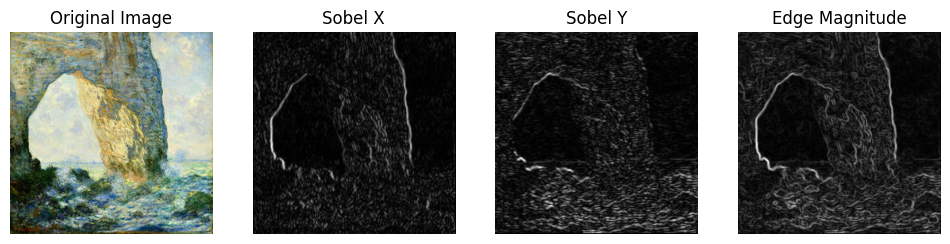

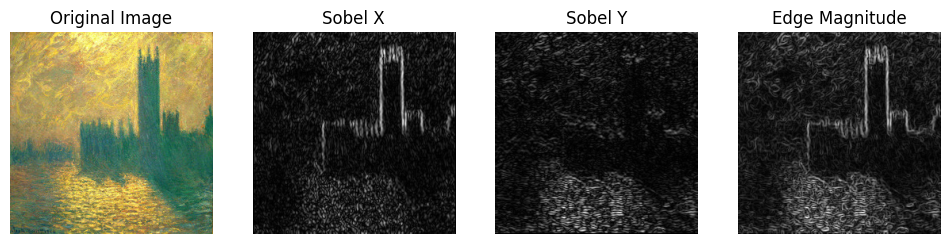

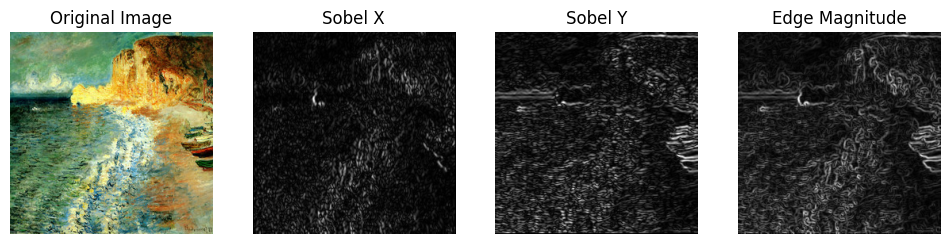

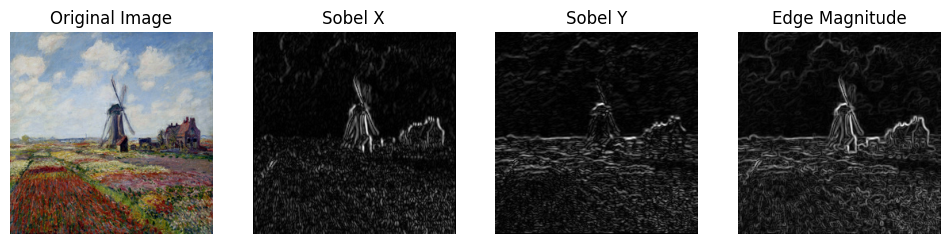

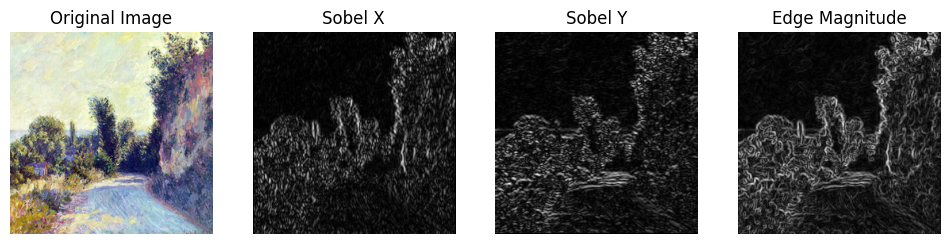

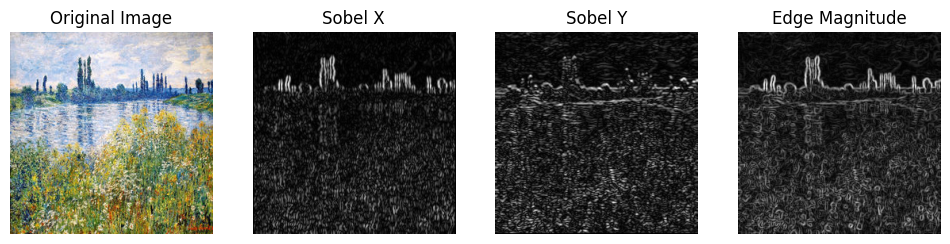

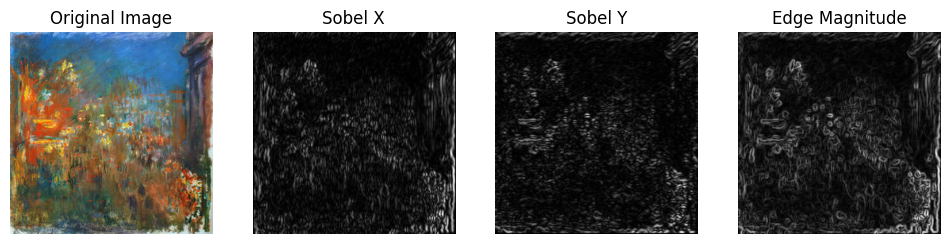

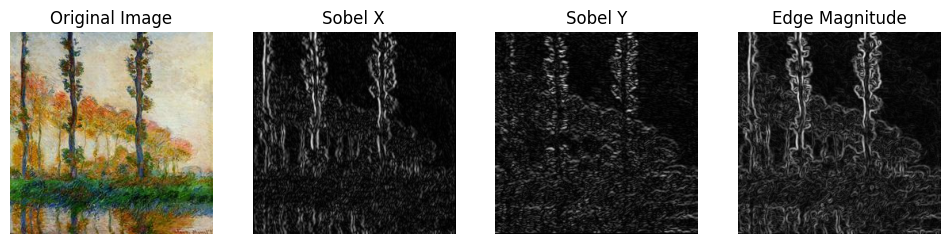

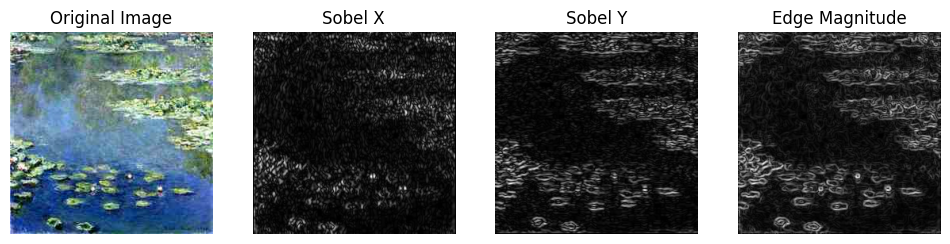

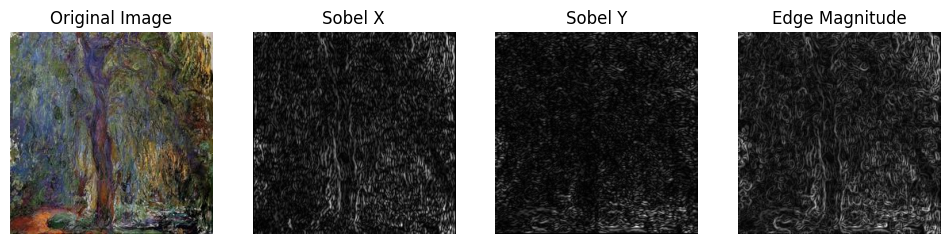

In [26]:
def sobel_edge_detection(image):
    img_np = ((image.numpy() * 0.5 + 0.5) * 255).astype(np.uint8)
    img = cv2.cvtColor(img_np[0], cv2.COLOR_RGB2GRAY)

    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)

    sobel_magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    sobel_orientation = np.arctan2(sobel_y, sobel_x) * (180 / np.pi)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(img_np[0], cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(np.abs(sobel_x), cmap='gray')
    plt.title("Sobel X")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(np.abs(sobel_y), cmap='gray')
    plt.title("Sobel Y")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(sobel_magnitude, cmap='gray')
    plt.title("Edge Magnitude")
    plt.axis("off")

    plt.show()

    return sobel_x, sobel_y, sobel_magnitude, sobel_orientation

for image in monet_ds.take(10):
    sobel_edge_detection(image)

### Analyzing Photo Dataset  

- Photos contain more well-defined, long edges that align with object contours.  
- Edge orientations are more diverse, reflecting the natural complexity of real-world scenes.  
- For example, the sky in photos lacks significant edges, whereas Monet’s paintings often depict texture and movement even in open spaces.  
  - This suggests that beyond just color adjustments, adding Monet-like texture in smooth areas (e.g., skies) could enhance the artistic transformation.

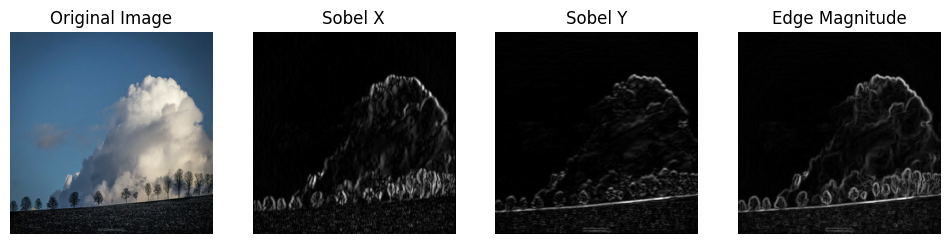

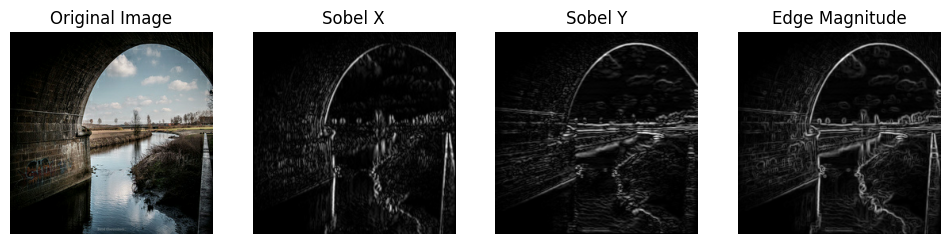

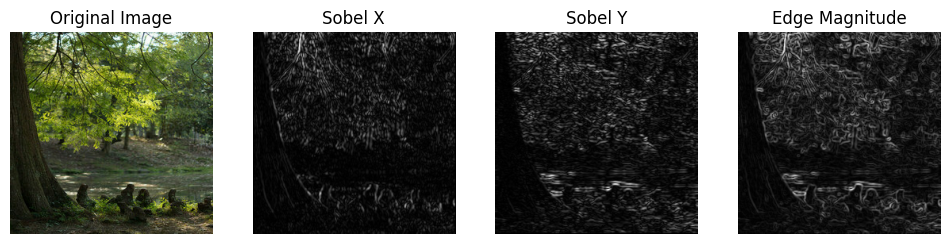

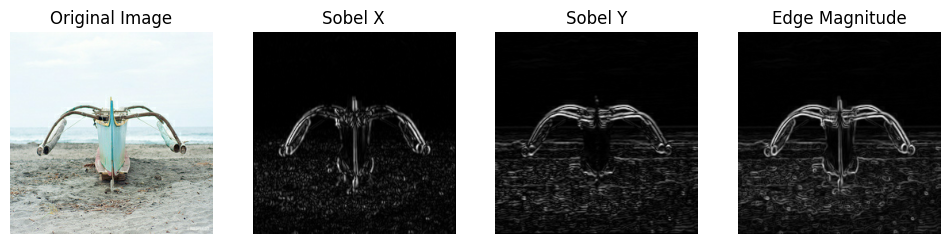

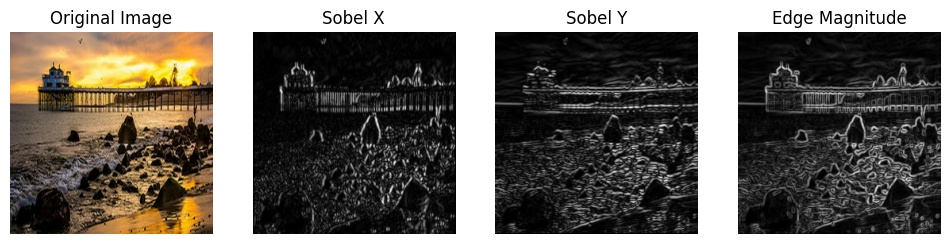

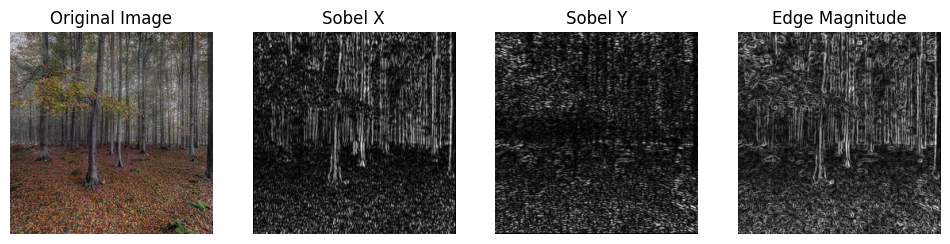

In [27]:
for image in photo_ds.take(6):
    sobel_edge_detection(image)

## EDA summary

- Extracted 100 images each from the Monet and photo datasets and calculated the mean and standard deviation for each RGB channel.  
- Plotted box plots to visualize the distribution trends:  
  - The analysis revealed that Monet's paintings use distinct, vibrant colors with some bias, meaning the color distribution is more constrained compared to photos.  
  - This observation aligns with the visually recognizable characteristics of Monet's style.  
- Applied computer vision techniques such as Sobel filters and Canny edge detection to analyze edge characteristics in both datasets:  
  - Monet's paintings exhibit short, strong horizontal brushstrokes, which are a distinctive stylistic feature.  
- Strategic implications:  
  - When generating images, preserving the original texture and brushstroke characteristics would be ideal for maintaining artistic fidelity.

# Model Architecture

Three types of architectures will appear in this challenge. GAN, Generator, and Discriminator.
This section provides an overview of each.

## GAN Architecture: CycleGAN  

This task involves translating between two unpaired groups of images. A suitable GAN architecture for such tasks is CycleGAN, proposed by Zhu et al. in 2017.  

### Brief Background  

The simplest form of a GAN learns to generate meaningful data from noise, typically handling a single domain.  
In contrast, image-to-image translation involves two domains: one for the input images and one for the transformed outputs.  

For problems where paired data exists (e.g., mapping aerial images to maps), models like Pix2Pix have been effective.  
However, when paired data is unavailable, CycleGAN provides a solution by learning transformations without direct (x, y) correspondences.  

When training a generator $G: X \to Y$, conventional GANs rely on paired data \((x, y)\) to directly evaluate whether $G(x)$ is a valid $Y$.  
However, since CycleGAN operates without paired data, the model has no direct guidance on which $x \in X$ should map to which $y \in Y$.  

As a result, adversarial loss alone is insufficient, since:
- The generator may learn to generate average-looking Y samples rather than meaningful transformations.
- Adversarial loss only enforces "realism" but does not guarantee that the transformed image retains the original structure**.  

To address this, CycleGAN introduces an inverse mapping $F: Y \to X$ and enforces a cycle consistency loss, ensuring that transformations remain meaningful:  
$$
X \to Y \to X \quad \text{(should approximately recover the original $X$)}
$$

## Loss Functions  

CycleGAN optimizes three key loss functions:

### Adversarial Loss
CycleGAN employs adversarial loss like standard GANs. The generator learns to convert domain $X$ images into domain $Y$, while the discriminator $D_Y$ distinguishes real $Y$ images from generated ones.

$$
\mathcal{L}_{GAN}(G, D_Y, X, Y) = \mathbb{E}_{y \sim p_{data}(y)}[\log D_Y(y)] + \mathbb{E}_{x \sim p_{data}(x)}[\log (1 - D_Y(G(x)))]
$$

Similarly, for the inverse mapping $F: Y \to X$:

$$
\mathcal{L}_{GAN}(F, D_X, Y, X) = \mathbb{E}_{x \sim p_{data}(x)}[\log D_X(x)] + \mathbb{E}_{y \sim p_{data}(y)}[\log (1 - D_X(F(y)))]
$$


### Cycle Consistency Loss
A key feature of CycleGAN is cycle consistency loss, which ensures that transformations are reversible.  
This prevents the generator from arbitrarily mapping images, enforcing structure preservation.

$$
\mathcal{L}_{cycle}(G, F) = \mathbb{E}_{x \sim p_{data}(x)}[|| F(G(x)) - x ||_1] + \mathbb{E}_{y \sim p_{data}(y)}[|| G(F(y)) - y ||_1]
$$


### Identity Loss
To preserve colors and textures, CycleGAN sometimes includes identity loss.  
If an image $x$ already belongs to the target domain, it should remain mostly unchanged after transformation.

$$
\mathcal{L}_{identity}(G, F) = \mathbb{E}_{y \sim p_{data}(y)}[|| G(y) - y ||_1] + \mathbb{E}_{x \sim p_{data}(x)}[|| F(x) - x ||_1]
$$


### Final Objective
The full CycleGAN loss combines all the above components:

$$
\mathcal{L}(G, F, D_X, D_Y) = \mathcal{L}_{GAN}(G, D_Y, X, Y) + \mathcal{L}_{GAN}(F, D_X, Y, X) + \lambda_{cycle} \mathcal{L}_{cycle}(G, F) + 0.5 * \lambda_{cycle} \mathcal{L}_{identity}(G, F)
$$

where:
- $\lambda_{cycle}$ controls the strength of cycle consistency loss.
---

## References
- Zhu, J.-Y., Park, T., Isola, P., & Efros, A. A. (2017). Unpaired image-to-image translation using cycle-consistent adversarial networks. *arXiv preprint arXiv:1703.10593*. https://arxiv.org/abs/1703.10593
- Zhu, J.-Y., Park, T., Isola, P., & Efros, A. A. (2017). CycleGAN: Unpaired image-to-image translation. Retrieved from https://junyanz.github.io/CycleGAN
- TensorFlow Developers. (n.d.). CycleGAN tutorial: Unpaired image-to-image translation. Retrieved from https://www.tensorflow.org/tutorials/generative/cyclegan

In [7]:
# ref: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial?scriptVersionId=41589890&cellId=27

class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### **Define Loss Functions**  

- Implementing the loss functions used in CycleGAN.  
- The original implementation is from the official Kaggle competition tutorial, but additional comments have been added for clarity.  

**Reference:**  
[Monet CycleGAN Tutorial (Kaggle)](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial?scriptVersionId=41589890&cellId=27)  

- **Discriminator loss** measures how well the discriminator distinguishes between real and generated images.  
- The loss is computed separately for real and generated images to prevent imbalances in training when the sample sizes are uneven.  
- If both losses were combined, as in the example below, the discriminator might become biased toward always predicting one class if the dataset is imbalanced:  

```python
labels = tf.concat([tf.ones_like(real), tf.zeros_like(generated)], axis=0)
preds = tf.concat([real, generated], axis=0)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(labels, preds)
```  

- This could lead to a situation where the discriminator always predicts real or fake depending on which type of sample dominates the dataset.  
- By computing losses separately, the model ensures balanced learning, preventing the discriminator from collapsing into trivial predictions.

In [8]:
with strategy.scope():
    # input:
    #   real: discriminator's output corresponds to real images
    #   generated: discriminator's output corresponds to the generated images
    def discriminator_loss(real, generated):
        # compute real/generated loss independently to ensure that different real/fake sample numbers are not affected
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

- **Generator loss** is designed to ensure that the discriminator classifies the generated images as real.  
- The goal is to train the generator to produce images that are indistinguishable from real ones, maximizing the discriminator's probability of predicting "real" for generated samples.

In [9]:
with strategy.scope():
    # input: discriminator's output corresponds to the generated image
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(
            from_logits=True,
            reduction=tf.keras.losses.Reduction.NONE
        )(tf.ones_like(generated), generated)

- **Cycle loss** compares the original image with $F(G(x))$ to ensure that the transformation is reversible.  
- It is computed as an L1 loss, measuring the mean pixel-wise difference between the original and reconstructed image.  
- To balance its importance relative to the adversarial loss, a weighting factor $\lambda$ is applied (Zhu et al., 2017).

In [10]:
with strategy.scope():
    # inputs:
    #   real_image: the original image (x or y)
    #   cycled_image: the cycled image (F(G(x)) or G(F(y)))
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

- **Identity loss** is described as a useful technique for preserving color mapping, particularly in painting → photo transformations (Zhu et al., 2017).  
- Its purpose is to prevent unnecessary transformations when the input image already belongs to the target domain. This ensures that the model does not alter images that do not require conversion.  
- However, identity loss is not essential for training but rather an additional constraint to improve the model's behavior in real-world applications.

In [11]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

## **Generator Architecture**  

The Generator model is constructed based on the CycleGAN framework, which consists of two Generators: $G$ (photo → Monet) and $F$ (Monet → photo). These models share the same architecture but learn different transformations.  

In CycleGAN, the Generator takes an input image and directly generates the transformed image. Unlike an Encoder-Decoder model that maps inputs to a latent space and reconstructs them, the Generator must preserve the overall structure of the image while changing its style.  

To achieve this, architectures like ResNet with Residual Blocks or U-Net are commonly used.  

For this experiment, we chose U-Net, as it offers a relatively simpler architecture while still maintaining important structural details of the input.  

The U-Net implementation is based on the [TensorFlow Tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix).

In [12]:
# --- Encoder (Downsampling) ---
def downsample(filters, size=4, apply_batchnorm=True):
      initializer = tf.random_normal_initializer(0., 0.02)
      result = tf.keras.Sequential()
      result.add(
          tf.keras.layers.Conv2D(
              filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)
          )
      if apply_batchnorm:
          result.add(tf.keras.layers.BatchNormalization())
      result.add(tf.keras.layers.LeakyReLU())

      return result

# --- Decoder (Upsampling) ---
def upsample(filters, size=4, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters, size, strides=2,
            padding='same',
            kernel_initializer=initializer,
            use_bias=False
        )
    )
    
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    
    return result

def Generator(input_shape=(256, 256, 3)):
    inputs = keras.Input(shape=input_shape)

    down_stack = [
        downsample(64, apply_batchnorm=False),  # (128, 128, 64)
        downsample(128),  # (64, 64, 128)
        downsample(256),  # (32, 32, 256)
        downsample(512),  # (16, 16, 512)
        downsample(512),  # (8, 8, 512)
        downsample(512),  # (4, 4, 512)
        downsample(512),  # (2, 2, 512)
        downsample(512)   # (1, 1, 512)
    ]

    up_stack = [
        upsample(512, apply_dropout=True),  # (2, 2, 512)
        upsample(512, apply_dropout=True),  # (4, 4, 512)
        upsample(512, apply_dropout=True),  # (8, 8, 512)
        upsample(512),  # (16, 16, 512)
        upsample(256),  # (32, 32, 256)
        upsample(128),  # (64, 64, 128)
        upsample(64)    # (128, 128, 64)
    ]

    # --- Connect Encoder & Decoder (Skip Connections) ---
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])  # To not skip the last layer, omit skips[-1]

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    # --- Output Layer ---
    x = layers.Conv2DTranspose(3, 4, strides=2, padding="same", activation="tanh")(x)  # (256, 256, 3)

    return keras.Model(inputs, x)

generator = Generator()
generator.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 128, 128, 64)   │          3,072 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 64, 64, 128)    │        131,584 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 32, 32, 256)    │        525,312 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 16, 16, 512)    │      2,099,200 │ sequential_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, 8, 8, 512)      │      4,196,352 │ sequential_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_5 (Sequential) │ (None, 4, 4, 512)      │      4,196,352 │ sequential_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_6 (Sequential) │ (None, 2, 2, 512)      │      4,196,352 │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_7 (Sequential) │ (None, 1, 1, 512)      │      4,196,352 │ sequential_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_8 (Sequential) │ (None, 2, 2, 512)      │      4,196,352 │ sequential_7[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 2, 2, 1024)     │              0 │ sequential_8[0][0],    │
│                           │                        │                │ sequential_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_9 (Sequential) │ (None, 4, 4, 512)      │      8,390,656 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 4, 4, 1024)     │              0 │ sequential_9[0][0],    │
│ (Concatenate)             │                        │                │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_10             │ (None, 8, 8, 512)      │      8,390,656 │ concatenate_1[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 8, 8, 1024)     │              0 │ sequential_10[0][0],   │
│ (Concatenate)             │                        │                │ sequential_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_11             │ (None, 16, 16, 512)    │      8,390,656 │ concatenate_2[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 16, 16, 1024)   │              0 │ sequential_11[0][0],   │
│ (Concatenate)        

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

## **Discriminator Architecture**  

- The discriminator is adapted from the one used in Pix2Pix.  
- Since there are no paired images available as input, the corresponding parts have been removed.  
- This architecture is known as PatchGAN, which outputs an $N \times N$ map instead of a single real/fake label. This allows the model to determine which regions of the image appear realistic.

In [13]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')

    down1 = downsample(64, 4, False)(inp) # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(
        512, 4, strides=1,
        kernel_initializer=initializer,
        use_bias=False
    )(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)    
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(
        1, 4, strides=1,
        kernel_initializer=initializer
    )(zero_pad2) # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

discriminator = Discriminator()
discriminator.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_15 (Sequential)           │ (None, 128, 128, 64)        │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_16 (Sequential)           │ (None, 64, 64, 128)         │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_17 (Sequential)           │ (None, 32, 32, 256)         │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 34, 34, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 31, 31, 512)         │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 31, 31, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 31, 31, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_1 (ZeroPadding2D)     │ (None, 33, 33, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 30, 30, 1)           │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,767,361 (10.56 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

### Build and Train Model

Using the parts that have appeared so far, create an instance of the actual model to be trained.

In [34]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

In [35]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [36]:
history_cycle_gan_model = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25,
    verbose=1,
    batch_size=4,
)

Epoch 1/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 120s 149ms/step - monet_disc_loss: 0.6912 - monet_gen_loss: 5.3438 - photo_disc_loss: 0.6972 - photo_gen_loss: 5.3991
Epoch 2/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 49s 151ms/step - monet_disc_loss: 0.6551 - monet_gen_loss: 3.6524 - photo_disc_loss: 0.6657 - photo_gen_loss: 3.6186
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 49s 151ms/step - monet_disc_loss: 0.6515 - monet_gen_loss: 3.4182 - photo_disc_loss: 0.6579 - photo_gen_loss: 3.4124
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 48s 149ms/step - monet_disc_loss: 0.6460 - monet_gen_loss: 3.2587 - photo_disc_loss: 0.6522 - photo_gen_loss: 3.2649
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 48s 149ms/step - monet_disc_loss: 0.6402 - monet_gen_loss: 3.1109 - photo_disc_loss: 0.6468 - photo_gen_loss: 3.1210
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 47s 146ms/step - monet_disc_loss: 0.6384 - monet_gen_loss: 3.0038 - photo_disc_loss: 0.6408 - photo_gen_loss: 3.0269
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 49s 152ms/step - 

# Result and Analysis

In this section, I present the results of training the model and comparing it to other models, as well as the results of experiments in which the hyperparameters were varied.

In [17]:
def show_result(trained_generator):
    _, ax = plt.subplots(5, 2, figsize=(12, 12))
    for i, img in enumerate(photo_ds.take(5)):
        prediction = trained_generator(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    
        ax[i, 0].imshow(img)
        ax[i, 1].imshow(prediction)
        ax[i, 0].set_title("Input Photo")
        ax[i, 1].set_title("Monet-esque")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
    plt.show()

The transformed images appeared as follows:  
A grid-like pattern emerged on the output images, but the structure of the input photos was still preserved. This confirms that the transformation process itself did not completely break down. However, in terms of achieving a Monet-style painting effect, the results still appear to be incomplete and require further refinement.

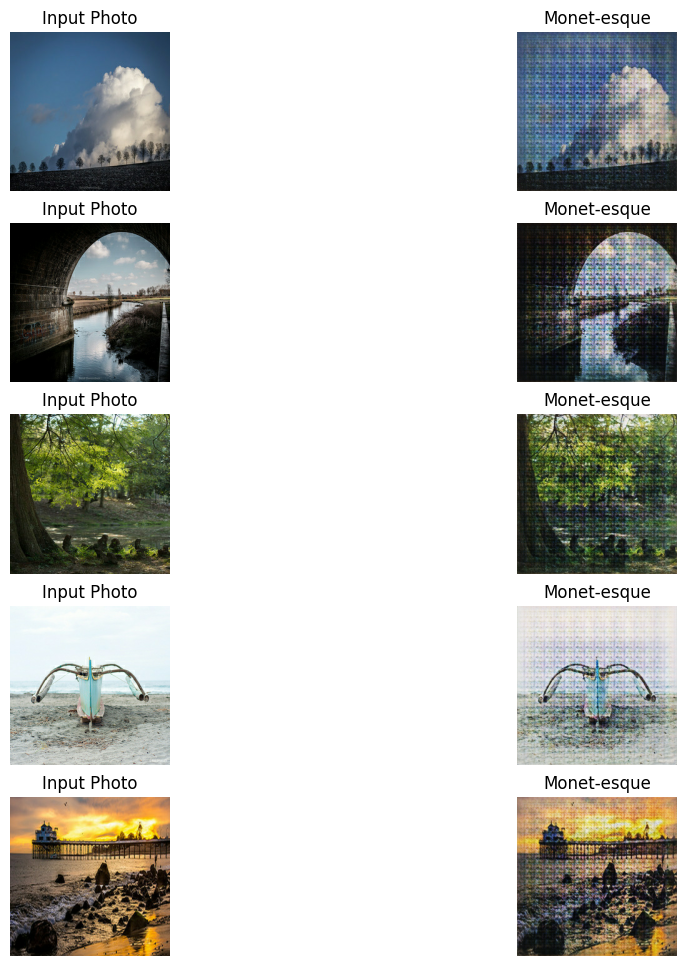

In [37]:
show_result(monet_generator)

## **Model Comparison**  

- Up to this point, the GANs used a U-Net architecture for the Generator.  
- As a comparison, how would the performance change if we use an Encoder-Decoder architecture without skip connections?

In [19]:
def EncoderDecoder(input_shape=(256, 256, 3)):
    inputs = keras.Input(shape=input_shape)

    # --- Encoder (Downsampling) ---
    down_stack = [
        downsample(64, apply_batchnorm=False),  # (128, 128, 64)
        downsample(128),  # (64, 64, 128)
        downsample(256),  # (32, 32, 256)
        downsample(512),  # (16, 16, 512)
        downsample(512),  # (8, 8, 512)
        downsample(512),  # (4, 4, 512)
        downsample(512),  # (2, 2, 512)
        downsample(512)   # (1, 1, 512)
    ]

    # --- Decoder (Upsampling) ---
    up_stack = [
        upsample(512, apply_dropout=True),  # (2, 2, 512)
        upsample(512, apply_dropout=True),  # (4, 4, 512)
        upsample(512, apply_dropout=True),  # (8, 8, 512)
        upsample(512),  # (16, 16, 512)
        upsample(256),  # (32, 32, 256)
        upsample(128),  # (64, 64, 128)
        upsample(64)    # (128, 128, 64)
    ]

    # --- Connect Encoder & Decoder (with no skip connections!) ---
    x = inputs
    for down in down_stack:
        x = down(x)

    for up in up_stack:
        x = up(x)

    # --- Output Layer ---
    x = layers.Conv2DTranspose(3, 4, strides=2, padding="same", activation="tanh")(x)  # (256, 256, 3)

    return keras.Model(inputs, x)

Assemble and train CycleGAN with EncoderDecoder:

In [22]:
with strategy.scope():
    monet_enc_dec = EncoderDecoder()
    photo_enc_dec = EncoderDecoder()

    monet_discriminator_2 = Discriminator()
    photo_discriminator_2 = Discriminator()

    cycle_gan_enc_dec = CycleGan(
        monet_enc_dec, photo_enc_dec, monet_discriminator_2, photo_discriminator_2
    )

    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    cycle_gan_enc_dec.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [23]:
history_cycle_gan_enc_dec = cycle_gan_enc_dec.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=10,
    verbose=1,
    batch_size=4,
)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 114s 131ms/step - monet_disc_loss: 0.0319 - monet_gen_loss: 15.9905 - photo_disc_loss: 0.0351 - photo_gen_loss: 16.4370
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 42s 130ms/step - monet_disc_loss: 9.6983e-04 - monet_gen_loss: 17.7193 - photo_disc_loss: 0.0011 - photo_gen_loss: 18.1099
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 42s 130ms/step - monet_disc_loss: 4.5722e-04 - monet_gen_loss: 18.3877 - photo_disc_loss: 4.6697e-04 - photo_gen_loss: 18.9750
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 43s 130ms/step - monet_disc_loss: 2.6999e-04 - monet_gen_loss: 18.8733 - photo_disc_loss: 2.5316e-04 - photo_gen_loss: 19.5009
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 43s 130ms/step - monet_disc_loss: 1.7955e-04 - monet_gen_loss: 19.2480 - photo_disc_loss: 1.7093e-04 - photo_gen_loss: 19.8103
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 43s 131ms/step - monet_disc_loss: 1.3314e-04 - monet_gen_loss: 19.4953 - photo_disc_loss: 1.2176e-04 - photo_gen_loss: 20.1187
Epoch 7/1

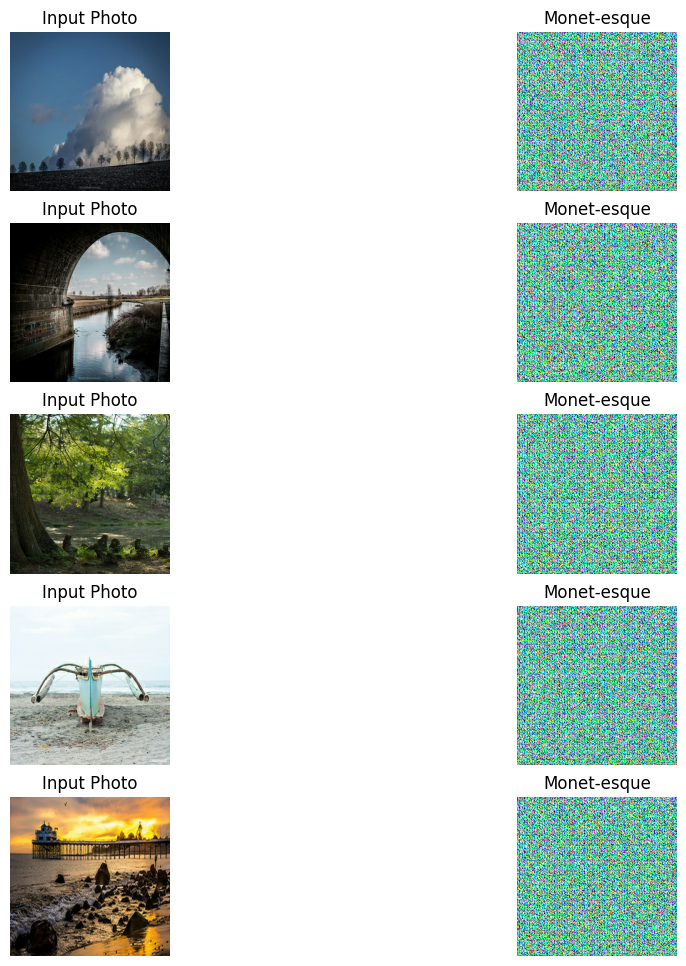

In [24]:
show_result(monet_enc_dec)

As a result, the model ended up generating completely meaningless noise images.  

The learning curves show that the discriminator starts with an extremely low loss and continues decreasing, while the generator's loss diverges. This suggests that if the generator lacks mechanisms to preserve and convey input features, the initially generated images become too easy for the discriminator to classify. Consequently, even with cycle consistency loss, the training fails to maintain balance, ultimately leading to a breakdown in learning.

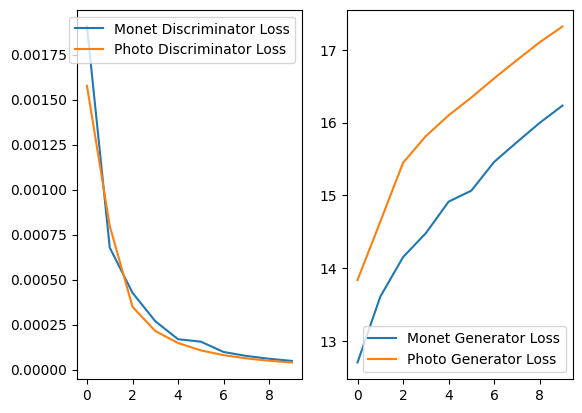

In [101]:
plt.subplot(121)
plt.plot([np.mean(b[-1], axis=(1, 0)) for b in history_cycle_gan_enc_dec.history['monet_disc_loss']], label="Monet Discriminator Loss")
plt.plot([np.mean(b[-1], axis=(1, 0)) for b in history_cycle_gan_enc_dec.history['photo_disc_loss']], label="Photo Discriminator Loss")
plt.legend()

plt.subplot(122)
plt.plot([np.mean(b[-1], axis=(1, 0)) for b in history_cycle_gan_enc_dec.history['monet_gen_loss']], label="Monet Generator Loss")
plt.plot([np.mean(b[-1], axis=(1, 0)) for b in history_cycle_gan_enc_dec.history['photo_gen_loss']], label="Photo Generator Loss")
plt.legend()

plt.show()

## **Hyperparameter Tuning**  

- We conducted experiments by adjusting the weight of the cycle consistency loss, a key characteristic unique to CycleGAN.
- While the original paper sets the default value to 10, we examined how the model's performance changes when $\lambda = 5$ and $\lambda = 20$.

In [28]:
with strategy.scope():
    monet_generator_l5 = Generator()
    photo_generator_l5 = Generator()

    monet_discriminator_l5 = Discriminator()
    photo_discriminator_l5 = Discriminator()

    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    cycle_gan_model_l5 = CycleGan(
        monet_generator_l5, photo_generator_l5, monet_discriminator_l5, photo_discriminator_l5, lambda_cycle=5
    )

    cycle_gan_model_l5.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [84]:
history_cycle_gan_model_l5 = cycle_gan_model_l5.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25,
    verbose=1,
    batch_size=4,
)

Epoch 1/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 48s 147ms/step - monet_disc_loss: 0.6704 - monet_gen_loss: 1.8270 - photo_disc_loss: 0.6621 - photo_gen_loss: 1.8698
Epoch 2/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 48s 148ms/step - monet_disc_loss: 0.6735 - monet_gen_loss: 1.8159 - photo_disc_loss: 0.6627 - photo_gen_loss: 1.8601
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 48s 150ms/step - monet_disc_loss: 0.6739 - monet_gen_loss: 1.7980 - photo_disc_loss: 0.6610 - photo_gen_loss: 1.8519
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 49s 150ms/step - monet_disc_loss: 0.6720 - monet_gen_loss: 1.8005 - photo_disc_loss: 0.6624 - photo_gen_loss: 1.8442
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 49s 150ms/step - monet_disc_loss: 0.6688 - monet_gen_loss: 1.7892 - photo_disc_loss: 0.6610 - photo_gen_loss: 1.8296
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 48s 149ms/step - monet_disc_loss: 0.6683 - monet_gen_loss: 1.7774 - photo_disc_loss: 0.6607 - photo_gen_loss: 1.8247
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 48s 149ms/step - m

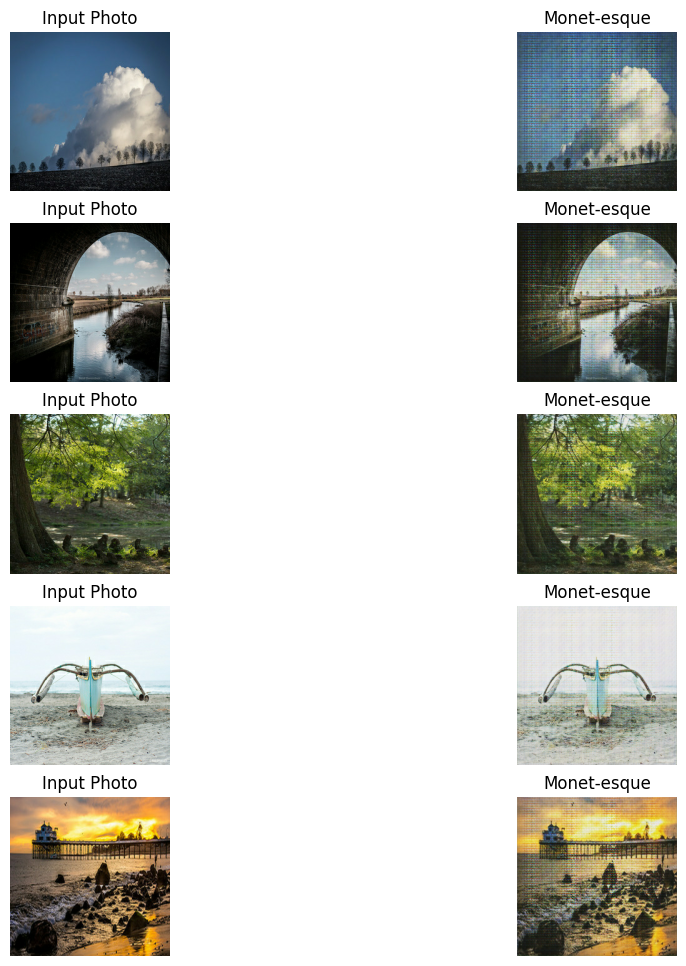

In [85]:
show_result(monet_generator_l5)

When $\lambda = 5$, the generator loss improved to around 1.7, whereas with $\lambda = 10$, the loss was approximately 2.7. This suggests that in this training setup, a slightly smaller $\lambda$ produced better results.  

Visually, the noise was slightly reduced, and in particular, the second image exhibited a texture that somewhat resembled a painting.

In [81]:
with strategy.scope():
    monet_generator_l20 = Generator()
    photo_generator_l20 = Generator()

    monet_discriminator_l20 = Discriminator()
    photo_discriminator_l20 = Discriminator()
    
    cycle_gan_model_l20 = CycleGan(
        monet_generator_l20, photo_generator_l20, monet_discriminator_l20, photo_generator_l20, lambda_cycle=20
    )

    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    cycle_gan_model_l20.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [82]:
history_cycle_gan_model_l20 = cycle_gan_model_l20.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25,
    verbose=1,
    batch_size=4,
)

Epoch 1/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 165s 206ms/step - monet_disc_loss: 0.5452 - monet_gen_loss: 14.3201 - photo_disc_loss: 0.5231 - photo_gen_loss: 17.1312
Epoch 2/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 65s 206ms/step - monet_disc_loss: 0.2841 - monet_gen_loss: 14.2073 - photo_disc_loss: 0.4685 - photo_gen_loss: 16.7296
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 206ms/step - monet_disc_loss: 0.2618 - monet_gen_loss: 12.8670 - photo_disc_loss: 0.4228 - photo_gen_loss: 16.7923
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 65s 206ms/step - monet_disc_loss: 0.2812 - monet_gen_loss: 11.6268 - photo_disc_loss: 0.3924 - photo_gen_loss: 16.6162
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 207ms/step - monet_disc_loss: 0.2289 - monet_gen_loss: 11.7754 - photo_disc_loss: 0.3698 - photo_gen_loss: 17.4453
Epoch 8/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 65s 206ms/step - monet_disc_loss: 0.2541 - monet_gen_loss: 11.2940 - photo_disc_loss: 0.3657 - photo_gen_loss: 17.3294
Epoch 9/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 2

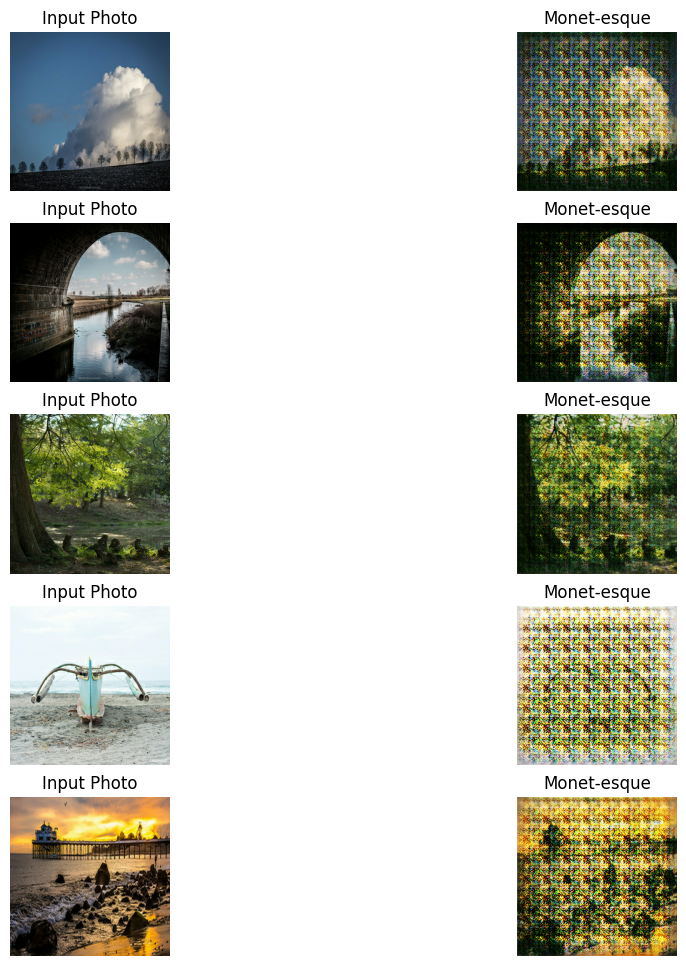

In [83]:
show_result(monet_generator_l20)

When $\lambda = 20$, the cycle consistency loss became too dominant compared to the adversarial loss, disrupting the balance between the generator and discriminator training. As a result, the model failed to perform effectively.

### **Summary and Conclusion**  

- As an exercise in GANs learned in Week 5, I worked on Kaggle’s *I’m Something of a Painter Myself* competition.  
- Through EDA, I analyzed the images and pointed out that preserving fine details during training might be crucial to maintaining Monet’s artistic style.  
- I selected CycleGAN as the model and provided a brief explanation of its principles.  
- After assembling the model, I performed image translation. While the training duration was short, I confirmed that CycleGAN was learning correctly despite the relatively low accuracy.  
- To further compare models, I replaced the Generator with an Encoder-Decoder structure and trained it, confirming that the choice of the Generator in CycleGAN significantly impacts the preservation of input image features through mechanisms like skip connections.  
- As part of hyperparameter tuning, I experimented with increasing and decreasing the cycle consistency loss coefficient *lambda*. In this setup, a smaller *lambda* resulted in a more balanced training process and higher-quality translations within a short training time.  
- To further improve the quality, extending the training duration would be the first consideration, followed by more fine-tuned adjustments.

# Generate Submission

In [ ]:
! mkdir ../images

In [ ]:
import PIL
import shutil

i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")